# Fine Grained Image Classification

## Importing Modules and Fixing Seeds

In [47]:
!pip install torchsummary
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import os
from PIL import Image

import torch
from torchsummary import summary
from torch import nn, optim
from torch.functional import F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable


SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


import os
os.environ['KAGGLE_USERNAME'] = "eitansharabi" #kaggle username
os.environ['KAGGLE_KEY'] = "fa2369efb52bae86402ea915d41066ef" #kaggle key
!kaggle competitions download -c dog-breed-identification

#Upload data and extract the contents
from zipfile import ZipFile
file_name = "/content/dog-breed-identification.zip"
with ZipFile(file_name, 'r') as zip:
 zip.extractall()
 print('done')

data_dir = ''
labels = pd.read_csv(os.path.join(data_dir, 'labels.csv'))
assert(len(os.listdir(os.path.join(data_dir, 'train'))) == len(labels))
labels.head()




from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y,test_size=0.4, random_state=SEED, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=SEED, stratify=y_valid)


class Dataset_Interpreter(Dataset):
    def __init__(self, data_path, file_names, labels=None, transforms=None):
        self.data_path = data_path
        self.file_names = file_names
        self.labels = labels
        self.transforms = transforms
        
    def __len__(self):
        return (len(self.file_names))
    
    def __getitem__(self, idx):
        img_name = f'{self.file_names.iloc[idx]}.jpg'
        full_address = os.path.join(self.data_path, img_name)
        image = Image.open(full_address)
        label = self.labels.iloc[idx]
        
        if self.transforms is not None:
            image = self.transforms(image)
            
        return np.array(image), label

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels.breed = le.fit_transform(labels.breed)
labels.head()
X = labels.id
y = labels.breed

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

def plot_training_statistics(train_stats, model_name):
    
    fig, axes = plt.subplots(2, figsize=(15,15))
    axes[0].plot(train_stats[f'{model_name}_Training_Loss'], label=f'{model_name}_Training_Loss')
    axes[0].plot(train_stats[f'{model_name}_Validation_Loss'], label=f'{model_name}_Validation_Loss')
    axes[1].plot(train_stats[f'{model_name}_Training_Acc'], label=f'{model_name}_Training_Acc')
    axes[1].plot(train_stats[f'{model_name}_Validation_Acc'], label=f'{model_name}_Validation_Acc')
    
    axes[0].set_xlabel("Number of Epochs"), axes[0].set_ylabel("Loss")
    axes[1].set_xlabel("Number of Epochs"), axes[1].set_ylabel("Accuracy in %")
    
    axes[0].legend(), axes[1].legend()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
dog-breed-identification.zip: Skipping, found more recently modified local copy (use --force to force download)
done


In [48]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = Variable(torch.FloatTensor(np.array(x))).to(device)
        y = Variable(torch.LongTensor(y)).to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [49]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = Variable(torch.FloatTensor(np.array(x))).to(device)
            y = Variable(torch.LongTensor(y)).to(device)
        
            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [50]:
def fit_model(model, model_name, train_iterator, valid_iterator, optimizer, loss_criterion, device, epochs):
    """ Fits a dataset to model"""
    best_valid_loss = float('inf')
    
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []
    
    for epoch in range(epochs):
    
        start_time = time.time()
    
        train_loss, train_acc = train(model, train_iterator, optimizer, loss_criterion, device)
        valid_loss, valid_acc = evaluate(model, valid_iterator, loss_criterion, device)
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accs.append(train_acc*100)
        valid_accs.append(valid_acc*100)
    
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f'{model_name}.pt')
    
        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

        
    return pd.DataFrame({f'{model_name}_Training_Loss':train_losses, 
                        f'{model_name}_Training_Acc':train_accs, 
                        f'{model_name}_Validation_Loss':valid_losses, 
                        f'{model_name}_Validation_Acc':valid_accs})

In [51]:
from torchvision import models
model = models.inception_v3(pretrained=True).to(device)
loss_criterion = nn.CrossEntropyLoss().to(device)
optimizer=optim.Adam(model.parameters())

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [52]:
for name, param in model.named_parameters():
    param.requires_grad = False

In [53]:
classifier = nn.Sequential(
            nn.Linear(model.fc.in_features, 120)
        )
model.fc = classifier.to(device)

optimizer = optim.Adam(model.parameters(), lr = 0.005)

In [55]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0)
train_transforms = transforms.Compose([transforms.Resize(299),
                               transforms.CenterCrop(299),
                               transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0),
                               transforms.RandomHorizontalFlip(p=0.5),
                               transforms.RandomVerticalFlip(p=0.5),
                               transforms.RandomGrayscale(p=0.1), 
                               transforms.ToTensor(),
                               normalize])
test_transforms = transforms.Compose([transforms.Resize(299),
                               transforms.CenterCrop(299),
                               transforms.ToTensor(),
                               normalize])

train_data = Dataset_Interpreter(data_path=data_dir+'train/', file_names=X_train, labels=y_train, transforms=train_transforms)
valid_data = Dataset_Interpreter(data_path=data_dir+'train/', file_names=X_valid, labels=y_valid, transforms=test_transforms)
test_data = Dataset_Interpreter(data_path=data_dir+'train/', file_names=X_test, labels=y_test, transforms=test_transforms)

BATCH_SIZE = 64

train_iterator = DataLoader(train_data, shuffle=True, batch_size= BATCH_SIZE)
valid_iterator = DataLoader(valid_data, batch_size=BATCH_SIZE)
test_iterator = DataLoader(test_data, batch_size = BATCH_SIZE)

Epoch: 01 | Epoch Time: 1m 27s
	Train Loss: 3.212 | Train Acc: 35.12%
	 Val. Loss: 0.625 |  Val. Acc: 81.93%
Epoch: 02 | Epoch Time: 1m 28s
	Train Loss: 2.043 | Train Acc: 53.99%
	 Val. Loss: 0.584 |  Val. Acc: 82.22%


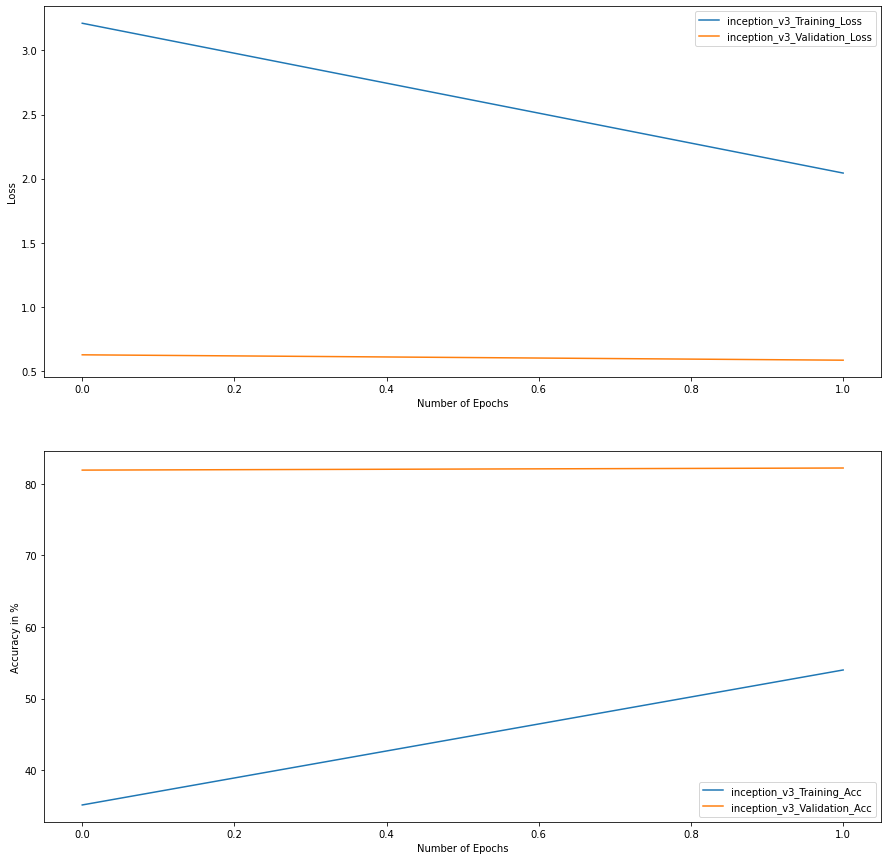

In [56]:
training_results = fit_model(model, 'inception_v3', train_iterator, valid_iterator, optimizer, loss_criterion, device, epochs=2)
plot_training_statistics(training_results, 'inception_v3')

In [57]:
torch.save(model.state_dict(), f'inception_v3.pt')

In [ ]:
state_dict = torch.load('inception_v3.pt')
model.load_state_dict(state_dict)
def test(model, test_loader, criterion):
    with torch.no_grad():
        model.eval()
        test_acc = 0
        for data, label in test_loader:
            data, label = data.cuda(), label.cuda()

            output = model(data)

            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(label.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            test_acc += accuracy.item() * data.size(0)

        test_acc = test_acc / len(test_loader.dataset)
        return test_acc

test_accuracy = test(model, test_iterator, loss_criterion)
print(test_accuracy)

0.851344743188844
